In [1]:
%matplotlib inline
import openmc as mc
import numpy as np
import matplotlib.pyplot as plt

## materials (fuel, clad, lbe) 

In [2]:
uranium = mc.Material(1, "depleted uranium")
uranium.add_nuclide('U238', 99.8, 'wo')
uranium.add_nuclide('U235', 0.2, 'wo')
uranium.add_nuclide('U234', 0.001, 'wo')
uranium.deplete = True

zirconium = mc.Material(2, "zirconium")
zirconium.add_element('Zr',1,'wo')

plutonium = mc.Material(3, "plutonium")
plutonium.add_nuclide('Pu238', 3.18, 'wo')
plutonium.add_nuclide('Pu239', 56.35, 'wo')
plutonium.add_nuclide('Pu240', 26.6, 'wo')
plutonium.add_nuclide('Pu241', 8.02, 'wo')
plutonium.add_nuclide('Pu242', 5.83, 'wo')
plutonium.deplete = True

upz = mc.Material.mix_materials([uranium, plutonium, zirconium], [0.8, 0.1, 0.1], 'wo')
upz.set_density('g/cc', 11.88)
upz.temperature = 800

In [3]:
lbe = mc.Material(5, "lead-bismuth-eutectic")

lbe.add_element('Pb', 44.5, 'wo')
lbe.add_element('Bi', 55.5, 'wo')

lbe.set_density('g/cc', 10.3)
lbe.temperature = 620.15

In [4]:
steel = mc.Material(6, "15-15Ti Steel")

steel.add_nuclide('C12', 0.1, 'wo')
steel.add_nuclide('Mn55', 1.49, 'wo')
steel.add_nuclide('Si28', 0.52, 'wo')
steel.add_nuclide('P31', 0.041, 'wo')

steel.add_element('Cr', 15.95, 'wo')
steel.add_element('Ni', 15.40, 'wo')
steel.add_element('B', 0.007, 'wo')
steel.add_element('Mo', 1.2, 'wo')
steel.add_element('Cu', 0.026, 'wo')
steel.add_element('V', 0.036, 'wo')
steel.add_element('Al', 0.023, 'wo')
steel.add_element('Ti', 0.44, 'wo')
steel.add_element('Fe', 64.767, 'wo')

steel.set_density('g/cc', 7.92)
steel.temperature = 750

In [5]:
mats = mc.Materials([upz, lbe, steel])
mats.export_to_xml()

# geometry

In [6]:
ac_top = mc.ZPlane(z0=70, boundary_type='vacuum')
ac_bottom = mc.ZPlane(z0=-70, boundary_type='vacuum')

f_radii = [0.74, 0.76, 0.78]
r_clad_radii = [0.77, 0.79, 0.81]

r_fuel = [mc.ZCylinder(r=ra) for ra in f_radii]
r_clad = [mc.ZCylinder(r=rc) for rc in r_clad_radii]

In [7]:
fuel = [mc.Cell(fill=upz, region=-cyl & +ac_bottom & -ac_top) for cyl in r_fuel]
clad = [mc.Cell(fill=steel, region=+f & -c & +ac_bottom & -ac_top) for f,c in zip(r_fuel,r_clad)]
coolant = [mc.Cell(fill=lbe, region=+c & -ac_top & +ac_bottom) for c in r_clad]
all_coolant_cell = mc.Cell(fill=lbe)

In [8]:
pin_universe = [mc.Universe(cells=[fuel[i],clad[i],coolant[i]], name='pin_for_zone '+str(i+1)) for i in [0,1,2]]
outer_universe = mc.Universe(cells=(all_coolant_cell,))
#outer_universe_for_assembly = mc.Universe(cells=(mc.Cell(fill=lbe, region=mc.model.hexagonal_prism(edge_length=16))))

In [9]:
lattice = [mc.HexLattice(name='assembly lattice:'+str(i+1)) for i in [0,1,2]]
    

In [10]:
for i in [0,1,2]:
    lattice[i].center = (0., 0.)
    lattice[i].pitch = (1.9, )
    lattice[i].outer = outer_universe
    lattice[i].orientation = 'x'
    rings = [[pin_universe[i]]*cir for cir in [24, 18, 12, 6, 1]]
    lattice[i].universes = rings

In [11]:
assem_region = mc.model.hexagonal_prism( edge_length=11.5, orientation='x', boundary_type='transmission')
assembly_cell = [mc.Cell(fill=lattice[i], region= assem_region & -ac_top & +ac_bottom) for i in [0,1,2]]
#outer_assembly_cell = mc.Cell(fill=lbe, region=-ac_top & +ac_bottom)

In [12]:
assembly_universe = [mc.Universe(cells=(assembly_cell[i],)) for i in [0, 1, 2]]


In [13]:
core_lat = mc.HexLattice(name='core_lattice_hex')

core_lat.center = (0., 0.)
core_lat.pitch = (16,)
core_lat.outer = outer_universe


In [14]:
reflective_ring = [outer_universe]*36
ring1 = [assembly_universe[2]]*30

ring2 = [assembly_universe[2]]*2 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]

ring3 = [assembly_universe[1]]*18

ring4 = [outer_universe] + [assembly_universe[1]]*5 +\
        [outer_universe] + [assembly_universe[1]]*5

ring5 = [assembly_universe[0]]*6
ring6 = [assembly_universe[0]]
        

In [15]:
core_lat.universes = [reflective_ring,ring1, ring2, ring3, ring4, ring5, ring6]

In [16]:
core_region = mc.model.hexagonal_prism(edge_length=110, orientation='y',boundary_type='vacuum')
core_cell = mc.Cell(fill=core_lat, region=core_region & -ac_top & +ac_bottom)
core_universe = mc.Universe(cells=(core_cell,))

In [17]:
geom = mc.Geometry()
geom.root_universe = core_universe
geom.export_to_xml()

In [18]:
bounds = [-85, -85, -70, 85, 85, 70]
uniform_dist = mc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
src = mc.Source(space=uniform_dist)

In [19]:
settings = mc.Settings()
settings.source = src
settings.batches = 60
settings.inactive = 20
settings.particles = 2000000
settings.generations_per_batch = 3
settings.temperature = {'method':'interpolation'}
settings.trigger_active = True
settings.trigger_batch_interval = 1
settings.trigger_max_batches = 120

settings.output = {'tallies': True}

In [20]:
settings.export_to_xml()

In [21]:
tallies = mc.Tallies()

In [22]:
fuel_cell_filter = mc.CellFilter(fuel)
clad_cell_filter = mc.CellFilter(clad)
coolant_cell_filter = mc.CellFilter(coolant)

trigger = mc.Trigger(trigger_type='rel_err', threshold=5e-3)
trigger.scores = ['flux', 'fission']

fuel_cell_tally = mc.Tally(name='fuel_cell fuel_cell_tally')
fuel_cell_tally.filters = [fuel_cell_filter]
fuel_cell_tally.scores = ['flux', 'fission']
fuel_cell_tally.triggers = [trigger]

tallies.append(fuel_cell_tally)

clad_coolant_fuel_cell_tally = mc.Tally(name='clad_coolant_Cell_fuel_cell_tally')
clad_coolant_fuel_cell_tally.filters = [clad_cell_filter, coolant_cell_filter]
clad_coolant_fuel_cell_tally.scores = ['absorption', 'scatter']

tallies.append(clad_coolant_fuel_cell_tally)

In [23]:
tallies.export_to_xml()

In [24]:
mc.run(threads=3)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

       28/3    1.00476    1.00540 +/- 0.00012
       29/1    1.00547    1.00540 +/- 0.00012
       29/2    1.00473    1.00537 +/- 0.00011
       29/3    1.00593    1.00539 +/- 0.00011
       30/1    1.00561    1.00540 +/- 0.00011
       30/2    1.00442    1.00537 +/- 0.00011
       30/3    1.00603    1.00539 +/- 0.00011
       31/1    1.00471    1.00537 +/- 0.00011
       31/2    1.00563    1.00538 +/- 0.00010
       31/3    1.00577    1.00539 +/- 0.00010
       32/1    1.00466    1.00537 +/- 0.00010
       32/2    1.00575    1.00538 +/- 0.00010
       32/3    1.00542    1.00538 +/- 0.00010
       33/1    1.00687    1.00542 +/- 0.00010
       33/2    1.00496    1.00541 +/- 0.00010
       33/3    1.00556    1.00541 +/- 0.00010
       34/1    1.00452    1.00539 +/- 0.00010
       34/2    1.00526    1.00539 +/- 0.00009
       34/3    1.00551    1.00539 +/- 0.00009
       35/1    1.00520    1.00538 +/- 0.00009
       35/2    1.00503    1.00538 +/- 0.00009
       35/3    1.00581    1.00539 

In [25]:
!cat tallies.out

 ==============>     TALLY 1: FUEL_CELL FUEL_CELL_TALLY     <===============

 Cell 1
   Total Material
     Flux                                 9.97149 +/- 0.00203293
     Fission Rate                         0.0456603 +/- 9.88814e-06
 Cell 2
   Total Material
     Flux                                 33.5680 +/- 0.00437229
     Fission Rate                         0.153713 +/- 1.85138e-05
 Cell 3
   Total Material
     Flux                                 31.9402 +/- 0.0034952
     Fission Rate                         0.145968 +/- 1.61482e-05
 ==========>     TALLY 2: CLAD_COOLANT_CELL_FUEL_CELL_TALLY     <===========

 Cell 4
   Cell 7
     Total Material
       Absorption Rate                      0.00000 +/- 0.00000
       Scattering Rate                      0.00000 +/- 0.00000
   Cell 8
     Total Material
       Absorption Rate                      0.00000 +/- 0.00000
       Scattering Rate                      0.00000 +/- 0.00000
   Cell 9
     Total Material
       Absorptio

In [27]:
sp = mc.StatePoint('statepoint.060.h5')

In [28]:
tally = sp.get_tally(scores=['flux'])
print(tally)0.26055 +/- 0.00003




Tally
	ID             =	1
	Name           =	fuel_cell fuel_cell_tally
	Filters        =	CellFilter
	Nuclides       =	total
	Scores         =	['flux', 'fission']
	Estimator      =	tracklength


In [29]:
print(tally.sum)

[[[ 398.85978678    1.82641004]]

 [[1342.71880689    6.14851731]]

 [[1277.60952479    5.83870612]]]


In [30]:
print(tally.mean)

[[[ 9.97149467  0.04566025]]

 [[33.56797017  0.15371293]]

 [[31.94023812  0.14596765]]]


In [31]:
print(tally.mean.shape)

(3, 1, 2)


In [32]:
flux = tally.get_slice(scores=['flux'])
fission = tally.get_slice(scores=['fission'])

In [33]:
print(flux)

Tally
	ID             =	3
	Name           =	fuel_cell fuel_cell_tally
	Filters        =	CellFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength


In [34]:
print(flux.shape)

(3, 1, 1)


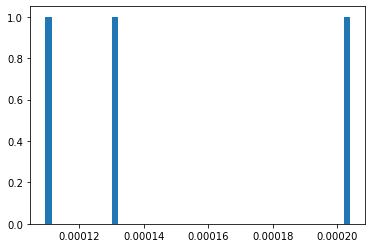

In [35]:
# Determine relative error
relative_error = np.zeros_like(flux.std_dev)
nonzero = flux.mean > 0
relative_error[nonzero] = flux.std_dev[nonzero] / flux.mean[nonzero]

# distribution of relative errors
ret = plt.hist(relative_error[nonzero], bins=50)

In [36]:
sp.source

array([((-44.59009401, -50.71190717,  43.75532938), ( 0.62722975, -0.47806291, -0.61484851),  633580.19439525, 1., 0, 0),
       ((-36.39229662, -41.12969365,  43.29586537), ( 0.64966476,  0.45399883,  0.60977107), 2207334.0704368 , 1., 0, 0),
       (( -6.99985049, -69.63850135, -18.61017681), ( 0.78699143, -0.61189632, -0.07891377), 2300527.09506056, 1., 0, 0),
       ...,
       ((  5.10512802,  77.66750289, -63.86073571), (-0.46577927, -0.75982081,  0.45356588),  497173.16538024, 1., 0, 0),
       (( -0.20276964,  76.70037183, -65.56606032), (-0.18124596,  0.16800885, -0.96898035), 4093559.168328  , 1., 0, 0),
       ((-14.00463348,  42.75480932, -22.06111988), (-0.93800356, -0.34166331,  0.05844231), 1404439.48350056, 1., 0, 0)],
      dtype={'names':['r','u','E','wgt','delayed_group','particle'], 'formats':[[('x', '<f8'), ('y', '<f8'), ('z', '<f8')],[('x', '<f8'), ('y', '<f8'), ('z', '<f8')],'<f8','<f8','<i4','<i4'], 'offsets':[0,24,48,56,64,68], 'itemsize':88})

In [38]:
sp.source['E']

array([ 633580.19439525, 2207334.0704368 , 2300527.09506056, ...,
        497173.16538024, 4093559.168328  , 1404439.48350056])

1.0


Text(0, 0.5, 'Probability/eV')

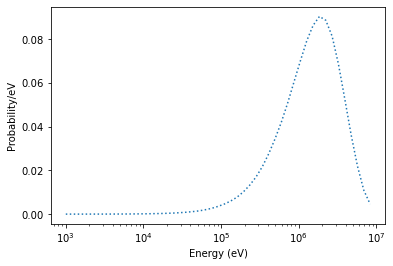

In [43]:
import numpy as np
energy_bins = np.logspace(3,7)

# Calculate pdf for source energies
probability, bin_edges = np.histogram(sp.source['E'], energy_bins, density=True)

# Make sure integrating the PDF gives us unity
print(sum(probability*np.diff(energy_bins)))

# Plot source energy PDF
plt.semilogx(energy_bins[:-1], probability*np.diff(energy_bins), linestyle='dotted')
plt.xlabel('Energy (eV)')
plt.ylabel('Probability/eV')

(-10.0, 10.0)

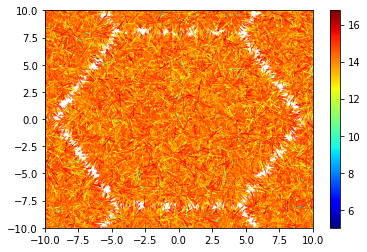

In [45]:
plt.quiver(sp.source['r']['x'], sp.source['r']['y'],
           sp.source['u']['x'], sp.source['u']['y'],
           np.log(sp.source['E']), cmap='jet', scale=20.0)
plt.colorbar()
plt.xlim((-10, 10))
plt.ylim((-10, 10))